In [ ]:
import cv2
import numpy as np
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras import models
import keras_tuner as kt
from utils import save_img_with_landmarks, extract_landmarks, load_model

In [7]:
def load_data(validation_split):

    # Load data from csv file into data frame, drop all rows that have missing values
    df = read_csv("training.csv")
    print(df["Image"].count())
    df = df.dropna()
    print(df["Image"].count())

    # Convert the rows of the image column from pixel values separated by spaces to numpy arrays
    df["Image"] = df["Image"].apply(lambda img: np.fromstring(img, sep=" "))

    # Create numpy matrix from image column by stacking the rows vertically
    X_data = np.vstack(df["Image"].values)
    # Normalize pixel values to (0, 1) range
    X_data = X_data / 255
    # Convert to float32, which is the default for Keras
    X_data = X_data.astype("float32")
    # Reshape each row from one dimensional arrays to (height, width, num_channels) = (96, 96, 1)
    X_data = X_data.reshape(-1, 96, 96, 1)
    # Extract labels representing the coordinates of facial landmarks
    Y_data = df[df.columns[:-1]].values

    # Normalize coordinates to (0, 1) range
    Y_data = Y_data / 96
    Y_data = Y_data.astype("float32")

    # Shuffle data
    X_data, Y_data = shuffle(X_data, Y_data)

    # Split data into training set and validation set
    split_index = int(X_data.shape[0] * (1 - validation_split))
    X_train = X_data[:split_index]
    Y_train = Y_data[:split_index]
    X_val = X_data[split_index:]
    Y_val = Y_data[split_index:]

    return X_train, Y_train, X_val, Y_val

In [6]:
X_train, Y_train, X_val, Y_val = load_data(validation_split=0.2)

7049
2140


# CNN Model

In [56]:
def create_cnn_model(hp):
    """fanction to to generate a combination of hyperparameter to use in RandomSearch

    Args:
        hp (hyperParameter): object to the control of combinations

    Returns:
        _type_: Sequential model
    """
    
    filters = hp.Choice('num_filters', values=[32, 64], default=64)
    units = hp.Int('units', min_value=32, max_value=512, step=32, default=128)
    activation = hp.Choice('dense_activation', values=['relu', 'tanh', 'sigmoid'], default='relu' )
    rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.01, sampling='LOG', default=0.001)
    
    model = models.Sequential([
        
        Conv2D(filters=filters, kernel_size=(5,5), input_shape=(96, 96, 1), activation=activation, padding="same"),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=filters, kernel_size=(5,5), activation=activation, padding="same"),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=filters, kernel_size=(5,5), activation=activation, padding="same"),
        Dropout(rate=rate),
        MaxPool2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=units, activation=activation),
        Dense(30)
    ])
    
    model.compile(optimizer="adam", loss="mean_squared_error")
    
    return model

In [64]:
from keras_tuner.tuners import Hyperband

tuner22 = Hyperband(
    create_cnn_model,
    max_epochs=10,
    objective='val_loss',
    seed=1,
    executions_per_trial=2,
    directory='hyperband',
    project_name='cifar10'
)

INFO:tensorflow:Reloading Oracle from existing project hyperband\cifar10\oracle.json


In [65]:
tuner22.search_space_summary()

Search space summary
Default search space size: 4
num_filters (Choice)
{'default': 64, 'conditions': [], 'values': [32, 64], 'ordered': True}
units (Int)
{'default': 128, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dense_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid'], 'ordered': False}
learning_rate (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [66]:
tuner22.search(X_train, Y_train,  epochs=10, validation_split=0.1)

Trial 32 Complete [00h 03m 26s]
val_loss: 0.0004247299220878631

Best val_loss So Far: 0.0004247299220878631
Total elapsed time: 01h 05m 41s
INFO:tensorflow:Oracle triggered exit


In [91]:
best_cnn_model = tuner22.get_best_models(num_models=1)[0]

In [92]:
best_cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0

In [93]:
cnn_val_loss = best_cnn_model.evaluate(X_val, Y_val)

14/14 [==============================] - 1s 41ms/step - loss: 4.5055e-04


In [94]:
cnn_val_loss

0.00045055351802147925

# Baseline model

In [77]:
def create_baseline_model():
    model = models.Sequential()
    model.add(Flatten(input_shape=(96, 96, 1)))
    model.add(Dense(512, activation="relu"))
    model.add(Dense(30))
    model.compile(optimizer="adam", loss="mean_squared_error")
    return model

In [85]:
baseline_model = create_baseline_model()
baseline_model.fit(X_train, Y_train, batch_size=200, epochs=10, validation_split=0.2)

Epoch 1/10
7/7 [==============================] - 1s 42ms/step - loss: 13.6284 - val_loss: 0.8532
Epoch 2/10
7/7 [==============================] - 0s 32ms/step - loss: 0.5061 - val_loss: 0.2486
Epoch 3/10
7/7 [==============================] - 0s 32ms/step - loss: 0.1931 - val_loss: 0.1460
Epoch 4/10
7/7 [==============================] - 0s 34ms/step - loss: 0.1383 - val_loss: 0.1209
Epoch 5/10
7/7 [==============================] - 0s 38ms/step - loss: 0.1100 - val_loss: 0.0950
Epoch 6/10
7/7 [==============================] - 0s 33ms/step - loss: 0.0843 - val_loss: 0.0734
Epoch 7/10
7/7 [==============================] - 0s 32ms/step - loss: 0.0632 - val_loss: 0.0555
Epoch 8/10
7/7 [==============================] - 0s 34ms/step - loss: 0.0466 - val_loss: 0.0407
Epoch 9/10
7/7 [==============================] - 0s 31ms/step - loss: 0.0345 - val_loss: 0.0314
Epoch 10/10
7/7 [==============================] - 0s 34ms/step - loss: 0.0262 - val_loss: 0.0251


In [81]:
final_val_loss = baseline_model.evaluate(X_val, Y_val)

14/14 [==============================] - 0s 5ms/step - loss: 0.0491


In [82]:
final_val_loss

0.049083102494478226

# save models

#### save cnn model

In [96]:
best_cnn_model.save_weights("saved_models/cnn_model_weights.h5")
with open("saved_models/cnn_model_architecture.json", "w") as f:
         f.write(best_cnn_model.to_json())

#### save baseline model

In [97]:
baseline_model.save_weights("saved_models/baseline_model_weights.h5")
with open("saved_models/baseline_model_architecture.json", "w") as f:
         f.write(baseline_model.to_json())

# Predict Landmarks

In [ ]:
img = X_val[0]
img_size_x, img_size_y = img.shape[0], img.shape[1]

# Plot correct landmarks
landmarks = extract_landmarks(Y_val[0], img.shape[0], img.shape[1])
save_img_with_landmarks(img, landmarks, "data_visual.png", gray_scale=True)
 
# Baseline model
model =  load_model("baseline")
y_pred = model.predict(np.expand_dims(img, axis=0))[0]
landmarks =  extract_landmarks(y_pred, img_size_x, img_size_y)
save_img_with_landmarks(img, landmarks, "baseline_prediction.png", gray_scale=True)

# CNN model
model =  load_model("cnn")
y_pred = model.predict(np.expand_dims(img, axis=0))[0]
landmarks = extract_landmarks(y_pred, img_size_x, img_size_y)
save_img_with_landmarks(img, landmarks, "cnn_prediction.png", gray_scale=True)

##### Sample Landmarks

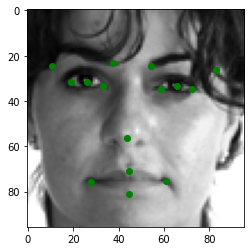

In [3]:
from PIL import Image

Image.open("output/data_visual.png")

#### CNN Landmarks Prediction 

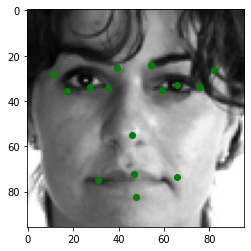

In [113]:
Image.open("output/cnn_prediction.png")

In [10]:
def sunglasses_filter(input_image_name:str, model_name:str='cnn', filter_name:str='sunglasses'):
    # Load original image
    face_img_path = "input/" + input_image_name + ".png"
    orig_img = cv2.imread(face_img_path)
    orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
    orig_size_x, orig_size_y = orig_img.shape[0], orig_img.shape[1]

    # Prepare input image
    img = cv2.imread(face_img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, dsize=(96, 96), interpolation=cv2.INTER_AREA)
    img = np.expand_dims(img, axis=2)
    img = img.astype("float32") / 255
    #img = img.astype("float32")

    # Predict landmarks
    
    model = load_model(model_name)
    y_pred = model.predict(np.expand_dims(img, axis=0))[0]
    landmarks = extract_landmarks(y_pred, orig_size_x, orig_size_y)

    # Save original image with landmarks on top
    save_img_with_landmarks(orig_img, landmarks, "landmarks"+ input_image_name + ".png")

    # Extract x and y values from landmarks of interest
    # eye position
    left_eye_center_x = int(landmarks[0][0])
    left_eye_center_y = int(landmarks[0][1])
    right_eye_center_x = int(landmarks[1][0])
    right_eye_center_y = int(landmarks[1][1])
    left_eye_outer_x = int(landmarks[3][0])
    right_eye_outer_x = int(landmarks[5][0])

    # Load images using PIL
    # PIL has better functions for rotating and pasting compared to cv2
    face_img = Image.open(face_img_path)
    sunglasses_img = Image.open("input/" + filter_name + ".png")

    # Resize sunglasses
    sunglasses_width = int((left_eye_outer_x - right_eye_outer_x) * 1.4)
    sunglasses_height = int(sunglasses_img.size[1] * (sunglasses_width / sunglasses_img.size[0]))
    sunglasses_resized = sunglasses_img.resize((sunglasses_width, sunglasses_height))

    # Rotate sunglasses
    eye_angle_radians = np.arctan((right_eye_center_y - left_eye_center_y) / (left_eye_center_x - right_eye_center_x))
    sunglasses_rotated = sunglasses_resized.rotate(np.degrees(eye_angle_radians), expand=True, resample=Image.BICUBIC)

    # Compute positions such that the center of the sunglasses is
    # positioned at the center point between the eyes
    x_offset = int(sunglasses_width * 0.5)
    y_offset = int(sunglasses_height * 0.5)
    pos_x = int((left_eye_center_x + right_eye_center_x) / 2) - x_offset
    pos_y = int((left_eye_center_y + right_eye_center_y) / 2) - y_offset

    # Paste sunglasses on face image
    face_img.paste(sunglasses_rotated, (pos_x, pos_y), sunglasses_rotated)
    
    face_img.save("output/" + input_image_name +"_"+ filter_name + ".png")
    
    landmarks_img = Image.open("output/landmarks"+ input_image_name + ".png")
    sunglasses_img = Image.open("output/"+ input_image_name +"_"+ filter_name + ".png")

    return landmarks_img, sunglasses_img

In [11]:
landmarks_img, sunglasses_img = sunglasses_filter('picard')

1/1 [==============================] - 0s 89ms/step


C:\Users\motaz\AppData\Local\Temp\ipykernel_10444\2061472754.py:45: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  sunglasses_rotated = sunglasses_resized.rotate(np.degrees(eye_angle_radians), expand=True, resample=Image.BICUBIC)


<Figure size 432x288 with 0 Axes>

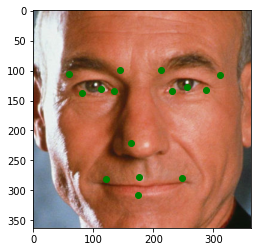

In [12]:
landmarks_img

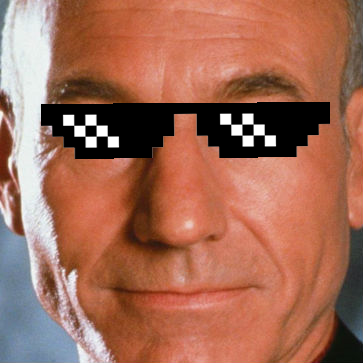

In [13]:
sunglasses_img

In [140]:
landmarks_img, sunglasses_img = sunglasses_filter('kid')

<Figure size 432x288 with 0 Axes>

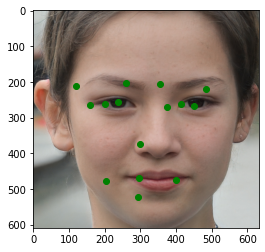

In [141]:
landmarks_img

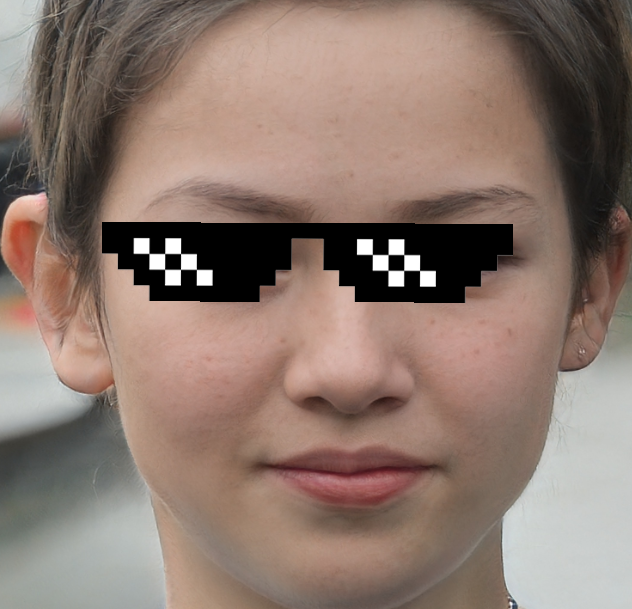

In [142]:
sunglasses_img

In [143]:
landmarks_img, sunglasses_img = sunglasses_filter('person')

<Figure size 432x288 with 0 Axes>

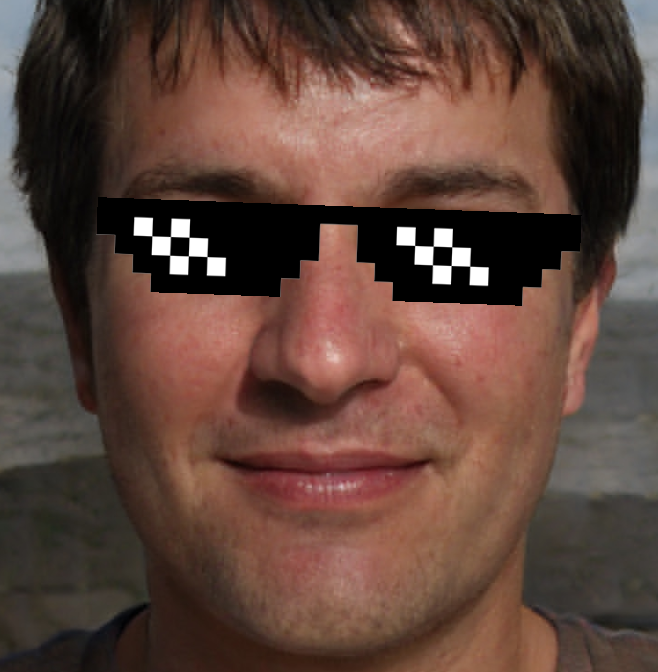

In [145]:
sunglasses_img

In [147]:
landmarks_img, sunglasses_img = sunglasses_filter('glasses')

<Figure size 432x288 with 0 Axes>

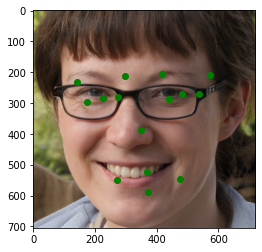

In [148]:
landmarks_img


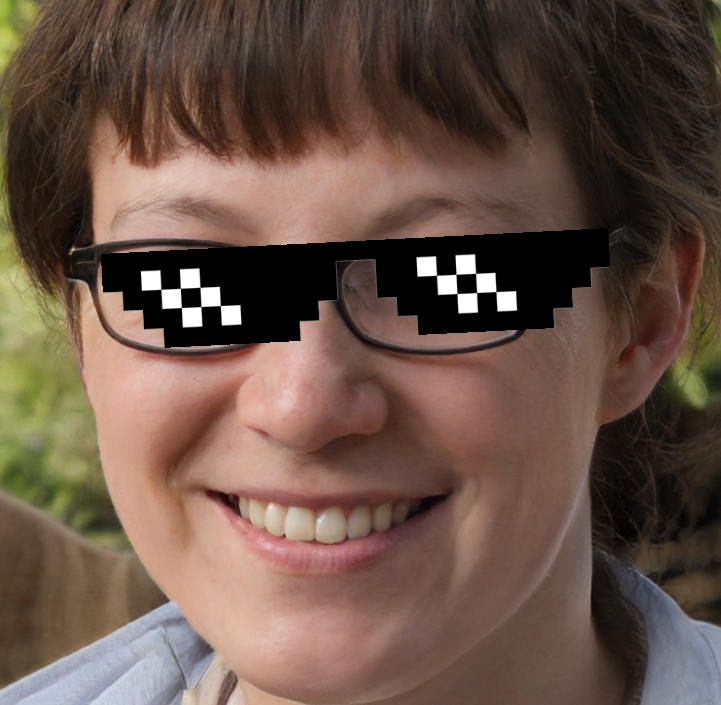

In [149]:
sunglasses_img